## Scattering Transform with ADID data


### First we load libraries and define some basic functions

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from kymatio.torch import Scattering1D

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from hyperopt.pyll.base import scope

torch.cuda.empty_cache()
#os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True" # Not supported on PC

# Set the random seed for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True #May slow things down but needed for replicability
        torch.backends.cudnn.benchmark = False#May slow things down but needed for replicability

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define the custom R-squared metric
def r2_metric(y_true, y_pred):
    # Residual sum of squares
    SS_res = torch.sum((y_true - y_pred) ** 2)
    
    # Total sum of squares
    SS_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
    
    # R-squared
    r2 = 1 - SS_res / (SS_tot + torch.finfo(torch.float32).eps)
    
    return r2


def evaluate_model_performance(y_true, y_pred):
    """
    Evaluate the performance of a Keras model predicting a continuous outcome.
    
    Parameters:
    y_true (array-like): True values
    y_pred (array-like): Predicted values

    Returns:
    dict: A dictionary containing RMSE, MAE, and R-squared metrics
    """
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # Calculate MAE
    mae = mean_absolute_error(y_true, y_pred)
    
    # Calculate R-squared
    r2 = r2_metric(y_true, y_pred)
    
    # Return all metrics in a dictionary
    return {
        'RMSE': rmse,
        'MAE': mae,
        'R-squared': r2
    }
    
#Create weighted scattering activation map with seaborn heatmap function
def create_activationMap(heatmap, num_features,ylabels,
                         colors="Greens", barLabel = "Feature importance",
                         title="Multivariate summary", vmin=-.2, vmax=.2, savefile = None):
    plt.figure(figsize=(12, 6))
    ax = sns.heatmap(heatmap, cmap=colors, cbar=True, xticklabels=True, yticklabels=False, vmin=vmin, vmax=vmax)

# Format the Colorbar
    cbar = ax.collections[0].colorbar
    cbar.set_label(barLabel, fontsize=16)
    cbar.ax.tick_params(labelsize=14)

    # 7Set Axis Labels & Titles
    plt.xlabel("Time", fontsize=18)
    plt.ylabel("Features", fontsize=18)
    plt.title(title, fontsize=20)

    # Add Time Window Labels (X-axis)
    num_T = heatmap.shape[-1]
    xtick_positions = np.linspace(0, num_T, min(20, num_T), dtype=int)
    ax.set_xticks(xtick_positions)
    ax.set_xticklabels(xtick_positions, fontsize=14)

    # Set Y-axis Tick Labels with Frequency Info
    yticks = np.arange(.5,num_features+.5)  
    y_labels = ylabels
    ax.set_yticks(ticks=yticks)
    ax.set_yticklabels(y_labels, fontsize=16)

    # Set Background to White
    ax.set_facecolor("white")
    
    if savefile != None:
        plt.savefig(savefile, format="pdf", bbox_inches="tight", dpi=600)
    
        # Show the heatmap
    plt.show()

#Flexible approach that tunes the number of layers and hidden dimension by hyperopt; in this specific implementation we double the hidden dimension for the first half only
class ScatteringNN_flex(nn.Module):
    def __init__(self, num_T, J, Q, hidden_dim, num_layers, dropout_rate):
        super(ScatteringNN_flex, self).__init__()
        self.scattering = Scattering1D(J=J, Q=Q, shape=(num_T,)).to(device)
        self.relu = nn.ReLU().to(device)
        self.fc_layers = None  # Fully connected layers will be initialized dynamically in forward step
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate
        if DEBUG: print("DONE INITIALIZING!")
    
    def forward(self, x):
        self.num_samples = x.shape[0]
        if DEBUG: print("Self.num_samples: ", self.num_samples)
        activation_maps = []
        self.num_features = x.shape[1]
        if DEBUG: print("Self.num_features: ", self.num_features)
        for i in range(self.num_features):
            # Ensure each feature slice is contiguous before processing
            # Apply Scattering1D to each time series
            x_i = x[:, i, :].contiguous().to(device, dtype=torch.float32)


            #Apply scattering1d
            feat_i = self.scattering(x_i).to(device)  # Scattering output
            feat_i = self.relu(feat_i).contiguous().to(device)
            feat_i_max, _ = torch.topk(feat_i, k=3, dim=1)#Find 3 max scattering coefficients across freq bands within each time window
            activation_maps.append(feat_i_max)

        if DEBUG: print("DONE SCATTERING!")
        
        # Concatenate the scattering coefficients from all features
        activation_maps = torch.cat(activation_maps, dim=1).contiguous().to(device)  # Shape: (num_samples, num_features * scattering output size, num_T//2**J)
        X_MLP = activation_maps.view(self.num_samples, -1).contiguous().to(device) # Shape: (num_samples, num_features * num_scattering_coeffs * num_windows) #UNCOMMENT THIS
        if DEBUG: print(f"Shape of X_MLP: {X_MLP.shape}")
        
        # Initialize fully connected layers dynamically based on the input size
        if self.fc_layers is None:
            fc_layers = []
            input_size = X_MLP.shape[1]
            
             # First layer (output size is 1)
            fc_layers.append(nn.Dropout(self.dropout_rate).to(device))
            fc_layers.append(nn.Linear(input_size, 1).to(device))
            fc_layers.append(nn.ReLU().to(device))
            fc_layers.append(nn.Dropout(self.dropout_rate).to(device))
            
            # Second layer (input size is 1, output size is hidden_dim)
            fc_layers.append(nn.Linear(1, self.hidden_dim).to(device))
            fc_layers.append(nn.ReLU().to(device))
            fc_layers.append(nn.Dropout(self.dropout_rate).to(device))
            
            # Additional layers where output size doubles
            current_hidden_dim = self.hidden_dim
            if (self.num_layers > 2):
                for h in range(2, self.num_layers):  # Adjust to account for the already added layers
                    next_hidden_dim = current_hidden_dim * 2
                    fc_layers.append(nn.Linear(current_hidden_dim, next_hidden_dim).to(device))
                    fc_layers.append(nn.ReLU().to(device))
                    fc_layers.append(nn.Dropout(self.dropout_rate).to(device))
                    current_hidden_dim = next_hidden_dim
            
            # Final output layer (size is num_T)
            fc_layers.append(nn.Linear(current_hidden_dim, num_T).to(device))
            self.fc_layers = nn.Sequential(*fc_layers).to(device)
        if DEBUG: print("DONE INITIALIZING FC_LAYERS!")
        # Forward pass through fully connected layers
        
        output = self.fc_layers(X_MLP).contiguous().to(device)
        if DEBUG: print("DONE GETTING OUTPUT!")
        ## Calculate weightedActivationMap
        W_MLP = self.fc_layers[1].weight.data.to(device) #Get first layer of weights
        
        if DEBUG: print("Shape of W_MLP: ", W_MLP.shape)
        if DEBUG: print("Shape of activation_maps after FC layers: ", activation_maps.shape)
        
        # Replicate the tensor num_samples times along the first dimension
        W_MLP2 = W_MLP.repeat(self.num_samples, 1)  # Now W_MLP2 is of size (num_samples, original shape[1] of W_MLP1)
        if DEBUG: print("Shape of W_MLP2 here: ", activation_maps.shape)
        
        activation_maps_reshaped = activation_maps.reshape(self.num_samples,-1)
        if DEBUG: print("Shape of W_MLP2 after reshaping: ", W_MLP2.shape)
        if DEBUG: print("Shape of activation_maps after reshaping: ", activation_maps_reshaped.shape)
        weightedActivationMap = W_MLP2 * activation_maps_reshaped

        # Reshape weightedActivationMap for heatmap generation
        weightedActivationMap = weightedActivationMap.view(x.size(0), x.shape[1], -1, feat_i.shape[-1])
        heatbyFP = weightedActivationMap # Averagecross persons but not frequency bands
        heatbyPerson = weightedActivationMap.mean(dim=2)#Average across frequency bands
        heat = heatbyPerson.mean(dim=0)
        if DEBUG: print("Shape of weightedActivationMap: ", weightedActivationMap.shape)
        if DEBUG: print("Shape of heat: ", heat.shape)
        if DEBUG: print("Shape of output: ", output.shape)
        if DEBUG: print ("Well done! Features extracted from scattering")
        return output, X_MLP, W_MLP, heat, heatbyPerson, heatbyFP


#Partially confirmed approach that consolidates all the scattering coefficients in X_MLP into out_dim = 1 before predicting output_dim*T time points
class ScatteringNN(nn.Module):
    def __init__(self, num_T, J, Q, dropout_rate):
        super(ScatteringNN, self).__init__()
        self.scattering = Scattering1D(J=J, Q=Q, shape=(num_T,)).to(device)
        self.relu = nn.ReLU().to(device)
        self.fc_layers = None  # Fully connected layers will be initialized dynamically in forward step
        self.dropout_rate = dropout_rate
        if DEBUG: print("DONE INITIALIZING!")
    
    def forward(self, x):
        self.num_samples = x.shape[0]
        if DEBUG: print("Self.num_samples: ", self.num_samples)
        activation_maps = []
        self.num_features = x.shape[1]
        if DEBUG: print("Self.num_features: ", self.num_features)
        for i in range(self.num_features):
            # Ensure each feature slice is contiguous before processing
            # Apply Scattering1D to each time series
            x_i = x[:, i, :].contiguous().to(device, dtype=torch.float32)


            #Apply scattering1d
            feat_i = self.scattering(x_i).to(device)  # Scattering output
            feat_i = self.relu(feat_i).contiguous().to(device)
            feat_i_max, _ = torch.topk(feat_i, k=3, dim=1)#Find 3 max scattering coefficients across freq bands within each time window
            activation_maps.append(feat_i_max)

        if DEBUG: print("DONE SCATTERING!")
        
        # Concatenate the scattering coefficients from all features
        activation_maps = torch.cat(activation_maps, dim=1).contiguous().to(device)  # Shape: (num_samples, num_features * scattering output size, num_T//2**J)
        X_MLP = activation_maps.view(self.num_samples, -1).contiguous().to(device) # Shape: (num_samples, num_features * num_scattering_coeffs * num_windows) #UNCOMMENT THIS

        if DEBUG: print(f"Shape of X_MLP: {X_MLP.shape}")
        
        # Initialize fully connected layers dynamically based on the input size
        if self.fc_layers is None:
            fc_layers = []
            input_size = X_MLP.shape[1]
            
             # First layer (output size is 1 = output_dim)
            fc_layers.append(nn.Dropout(self.dropout_rate).to(device))
            fc_layers.append(nn.Linear(input_size, 1).to(device)) #Output size = out_dim = 1
            fc_layers.append(nn.ReLU().to(device))
            fc_layers.append(nn.Dropout(self.dropout_rate).to(device))
            
            # Final output layer (size is num_T)
            fc_layers.append(nn.Linear(1, num_T).to(device)) #Predicts one continuous outcome
            self.fc_layers = nn.Sequential(*fc_layers).to(device)
        if DEBUG: print("DONE INITIALIZING FC_LAYERS!")
        # Forward pass through fully connected layers
        
        output = self.fc_layers(X_MLP).contiguous().to(device)
        if DEBUG: print("DONE GETTING OUTPUT!")
        ## Calculate weightedActivationMap
        W_MLP = self.fc_layers[1].weight.data.to(device) #Get second layer of weights       
        
        if DEBUG: print("Shape of W_MLP: ", W_MLP.shape)
        if DEBUG: print("Shape of activation_maps after FC layers: ", activation_maps.shape)
        
        # Replicate the tensor num_samples times along the first dimension
        W_MLP2 = W_MLP.repeat(self.num_samples, 1)  # Now W_MLP2 is of size (num_samples, original shape[1] of W_MLP1)
        if DEBUG: print("Shape of W_MLP2 here: ", activation_maps.shape)
        
        activation_maps_reshaped = activation_maps.reshape(self.num_samples,-1)
        if DEBUG: print("Shape of W_MLP2 after reshaping: ", W_MLP2.shape)
        if DEBUG: print("Shape of activation_maps after reshaping: ", activation_maps_reshaped.shape)
        weightedActivationMap = W_MLP2 * activation_maps_reshaped

        # Reshape weightedActivationMap for heatmap generation
        weightedActivationMap = weightedActivationMap.view(x.size(0), x.shape[1], -1, feat_i.shape[-1])
        heatbyFP = weightedActivationMap # Averagecross persons but not frequency bands
        heatbyPerson = weightedActivationMap.mean(dim=2)#Average across frequency bands
        heat = heatbyPerson.mean(dim=0)
        if DEBUG: print("Shape of weightedActivationMap: ", weightedActivationMap.shape)
        if DEBUG: print("Shape of heat: ", heat.shape)
        if DEBUG: print("Shape of output: ", output.shape)
        if DEBUG: print ("Well done! Features extracted from scattering")
        return output, X_MLP, W_MLP, heat, heatbyPerson, heatbyFP


In [2]:
set_seed(4323)
seednum = 4323
fig_path = "C:/Users/symii/Dropbox/MachineLearning/Kymatio/ADID_Lab/IMPS_Proceedings2024/Manuscript/ScatterT_AffectForecast_IMPSProc2025/Figures/"

### Read in ADID data and so some data wrangling

- Define variables to be used as features
- Put data into the array shape desired, split into training and test set.

In [3]:
df=pd.read_csv('AllSlide50msec.csv')
df['ID'].unique()
df.columns
df = df.dropna()
# prompt: make a new column by combining session and ID
df['Session_ID'] = df['session'] + '_' + df['ID'].astype(str)

# Remove rows containing values HPA_Slide_226 LPA_Slide_201 in the Session_D column
df = df[~df['Session_ID'].isin(['HPA_Slide_226', 'LPA_Slide_201'])] #These IDs have unusually long data streams from these conditions - possibly data collection error

dfi = df[~df['session'].isin(['Neu_Slide', 'HPA_Slide'])] #Only include LPA session

dfi['session'].unique() #Check

dfi2=dfi.copy()
dfi=dfi[['ID','GSR', 'ECG', 'skinTemp', 'CS', 'ZM',
       'self.report', 'heartRate', 'CS.int','ZM.int', 
       'ECG.RR', 'valence', 'arousal','session','Session_ID']]

# Number of time steps for each participant
time_steps = 3345 #Each time point = 50 msec
# Extract participant IDs and variables
participants = dfi['Session_ID'].unique()
#variables = ['GSR', 'CS.int', 'ZM.int', 'ECG.RR', 'heartRate', 'skinTemp', 'arousal', 'valence', 'self.report']
variables = np.array(dfi.columns.difference(['ID','Session_ID','CS','ZM','ECG','session']))

# Initialize the 3D array for features
num_variables = len(variables)
num_features = num_variables-1
num_participants = len(participants)
print("num_Features = ", num_features)
print("num_variables = ", num_variables)
print("num_participants", num_participants)
print("Variables to be used: ", variables)

data_array = np.zeros((num_participants, num_variables, time_steps))

# Fill the arrays = num_samples, num_features, time_steps
for i, participant in enumerate(participants):
    participant_data = dfi[dfi['Session_ID'] == participant][:time_steps]
    data_array[i, :, :] = participant_data[variables].values.T
print("Shape of data array: ", data_array.shape)

num_samples = data_array.shape[0] #Number of participants

num_Features =  8
num_variables =  9
num_participants 80
Variables to be used:  ['CS.int' 'ECG.RR' 'GSR' 'ZM.int' 'arousal' 'heartRate' 'self.report'
 'skinTemp' 'valence']
Shape of data array:  (80, 9, 3345)


Splitting data into training and test data sets

In [4]:
# Split the data into training and testing sets (e.g., 80/20 split)
train_indices, test_indices = train_test_split(np.arange(num_participants), test_size=0.2, random_state=seednum)
dim2=np.r_[0:6,7:9]
dim_dv=6
print('variables: ', variables)
print("Features: ", variables[dim2])
print("DV: ", variables[dim_dv])

train_indices = np.sort(train_indices)
test_indices = np.sort(test_indices)
Train_data = data_array[train_indices]
Test_data = data_array[test_indices]

print('Train data shape: ', Train_data.shape)
print('Test data shape: ', Test_data.shape)
print("IDs in training set: ", train_indices)
print("IDs in test set: ", test_indices)

X_train = Train_data[:,dim2,:] 
X_test = Test_data[:,dim2,:] 

y_train = Train_data[:,dim_dv,:] 
y_test = Test_data[:,dim_dv,:] 

# Print shapes of the resulting arrays
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

variables:  ['CS.int' 'ECG.RR' 'GSR' 'ZM.int' 'arousal' 'heartRate' 'self.report'
 'skinTemp' 'valence']
Features:  ['CS.int' 'ECG.RR' 'GSR' 'ZM.int' 'arousal' 'heartRate' 'skinTemp'
 'valence']
DV:  self.report
Train data shape:  (64, 9, 3345)
Test data shape:  (16, 9, 3345)
IDs in training set:  [ 2  3  4  5  6  7  8  9 10 11 12 14 15 16 17 18 19 20 21 23 24 26 27 28
 32 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 58 60
 61 64 65 66 67 68 69 70 71 72 73 74 75 77 78 79]
IDs in test set:  [ 0  1 13 22 25 29 30 31 33 55 56 57 59 62 63 76]
X_train shape: (64, 8, 3345)
X_test shape: (16, 8, 3345)
y_train shape: (64, 3345)
y_test shape: (16, 3345)


Standardize variables using training data means and SDs

In [5]:
#Standardize the training data by variables, store the means and standard deviations,
#and use the same means and standard deviations to standardize the test data

# Compute means for each variable in the second dimension (features),
# collapsed over all samples (first dimension) and time points (third dimension)
means = np.mean(Train_data, axis=(0,2))
stds = np.std(Train_data, axis=(0,2)) 
#means = np.mean(data_array, axis=(0,2))
#stds = np.std(data_array, axis=(0,2)) 

print("Means = ", means)
print("Stds = ", stds)

# Check where standard deviations are zero
zero_std_indices = np.where(stds == 0)
if zero_std_indices[0].size > 0:
    print("Zero standard deviation found for variables:", zero_std_indices)
    
# Standardize the train and test data using the same means and standard deviations from training data
#means[None, :, None] and stds[None, :, None] reshape the means and standard deviations to broadcast correctly across the original data array.

standardized_train_data = (Train_data - means[None, :, None]) / stds[None, :, None]
standardized_test_data = (Test_data - means[None, :, None]) / stds[None, :, None]

X_train_std = standardized_train_data[:,dim2,:]
X_test_std = standardized_test_data[:,dim2,:]
y_train_std = standardized_train_data[:,dim_dv,:]
y_test_std = standardized_test_data[:,dim_dv,:]

# Save the means and standard deviations in case helpful later
np.save('VariableMeans.npy', means) 
np.save('VariableStds.npy', stds)

# Save means and standard deviations to a CSV file
df_stats = pd.DataFrame({
    'Means': means.flatten(),
    'Standard Deviations': stds.flatten()
})
df_stats.to_csv('ByVariablemeans_std_devs.csv', index=False)

# Display shapes of the datasets for verification
print(f"Train Data Shape: {Train_data.shape}")
print(f"Standardized training data Shape: {standardized_train_data.shape}")
print(f"Standardized test Data Shape: {standardized_test_data.shape}")
print(f"Standardized X_train_std data Shape: {X_train_std.shape}")
print(f"Standardized X_test_std Shape: {X_test_std.shape}")
print(f"Standardized y_train_std data Shape: {y_train_std.shape}")
print(f"Standardized y_test_std Shape: {y_test_std.shape}")

# Display means and standard deviations used for standardization
print("\nMeans and Standard Deviations:")
print(df_stats)

Means =  [1.99771827e-02 6.28349152e-01 6.03118112e+02 8.17366309e-02
 4.93324187e+00 6.95883140e+01 4.69567291e+00 8.43847131e+01
 1.78671247e+00]
Stds =  [7.60135945e-02 3.67964362e-01 3.56848669e+03 1.80617566e-01
 2.58552331e+00 1.14457538e+01 1.60432286e+00 4.70889572e+00
 1.08992786e+00]
Train Data Shape: (64, 9, 3345)
Standardized training data Shape: (64, 9, 3345)
Standardized test Data Shape: (16, 9, 3345)
Standardized X_train_std data Shape: (64, 8, 3345)
Standardized X_test_std Shape: (16, 8, 3345)
Standardized y_train_std data Shape: (64, 3345)
Standardized y_test_std Shape: (16, 3345)

Means and Standard Deviations:
        Means  Standard Deviations
0    0.019977             0.076014
1    0.628349             0.367964
2  603.118112          3568.486691
3    0.081737             0.180618
4    4.933242             2.585523
5   69.588314            11.445754
6    4.695673             1.604323
7   84.384713             4.708896
8    1.786712             1.089928


Convert from numpy arrays to tensors for GPU use later

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert NumPy arrays to PyTorch tensors
X_train_std = torch.tensor(X_train_std).to(device)
X_test_std = torch.tensor(X_test_std).to(device)
y_train_std = torch.tensor(y_train_std).to(device)
y_test_std = torch.tensor(y_test_std).to(device)
X_train_std_reshaped = X_train_std.clone().detach().permute(0, 2, 1).to(device) #Make num_T the second dimension for LSTM
X_test_std_reshaped = X_test_std.clone().detach().permute(0, 2, 1).to(device)#Make num_T the second dimension for LSTM

print("Number of samples = ", num_samples)
print("Number of features = ", num_features)
print("Number of time points = ", time_steps)

Number of samples =  80
Number of features =  8
Number of time points =  3345


### Perform Scattering Transform

In [7]:
log_eps = 1e-7
DEBUG = False
 
# Initialize model
hidden_dim=8
dropout_rate=.01
J = 4
Q = 3
num_layers = 3
hidden_dim = 8
num_T = time_steps
#model_ScatterFlex = ScatteringNN_flex(num_T, J, Q, num_layers, hidden_dim, dropout_rate).to(device)
model_ScatterFlex = ScatteringNN(num_T, J, Q, dropout_rate).to(device)

# Forward pass test
output, X_MLP, W_MLP, heat, heatbyPerson, heatbyFP = model_ScatterFlex(X_train_std)

# Get model layer weights
#first_layer_weights = model_ScatterFlex.fc_layers[0].weight.data

# Print the weights
#print("Weights of the first layer:")
#print(first_layer_weights)

### Now we define an objective function to be used with hyperopt

In [8]:
DEBUG_O = False
epochs = 50
J = 4 # 3: Loss is around .84; r2 around .10; J = 4 has better loss (.79) and r2 (.18, .13); J = 5 (.83, r2 (.14, .1)); J = 6(.84, r2 (.11,.12))
Q = 3
model_spec = "1layer"
def objective_scatterValidation(params, x_in, y_in, validRatio = .2, x_in2 = None, y_in2 = None, model_spec = "flex"):
    num_T = x_in.size(2)


    # Initialize the model with hyperparameters from params
    if (model_spec == "flex"):
        model = ScatteringNN_flex(
        num_T=num_T,
        J=J,#params['J'],
        Q=Q,#params['Q'],
        hidden_dim=params['hidden_dim'],
        num_layers=params['num_layers'],
        dropout_rate=params['dropout_rate']).to(device)
    else:
        model = ScatteringNN(
            num_T=num_T,
            J=J,#params['J'],
            Q=Q,#params['Q'],
            dropout_rate=params['dropout_rate']).to(device)

    if DEBUG_O: print('Params received: ', params)
    
    
    if (validRatio > .0001):
        X_1, X_2, y_1, y_2 = train_test_split(x_in, y_in, test_size=validRatio, random_state=seednum)
    else:
        X_1 = x_in.to(device, dtype=torch.float32)
        y_1 = y_in.to(device, dtype=torch.float32)
        val_output = None
        r2_val = None
        
    # Run a dummy forward pass to initialize the layers
    _ = model(X_1)
    if DEBUG_O: print("PASSED THIS. ")
    
    # Define loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['l2_reg'])

    # Training loop 
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output_now, _, _, _, _, _ = model(X_1)
        loss = criterion(output_now.float(), y_1.float())
        loss.backward()
        optimizer.step()
        r2_1 = r2_metric(y_1.float(), output_now.float())
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}, R2: {r2_1}") #Extract the scalar loss value (and not other associated by products)
    
    model.eval()
    if (x_in2 is not None and y_in2 is not None): #Doing predictions for test data provided by user
        with torch.no_grad():
            if DEBUG_O: print("I got here with x_in2 of shape: ", x_in2.shape)
            val_output, _, _, _, _, _  = model(x_in2)
            val_loss = criterion(val_output, y_in2).item()
            r2_val = r2_metric(y_in2.float(), val_output.float())
            print("Validation loss: ", val_loss) 
    else:
        with torch.no_grad(): #Doing predictions for validation data split from initial training data
            if DEBUG_O: 
                print("Got here instead!")
                print("Shape of X_2: ", X_2.shape)
                print("Shape of y_2: ", y_2.shape)
            val_output, _, _, _, _, _  = model(X_2)
            val_loss = criterion(val_output, y_2).item()
            r2_val = r2_metric(y_2.float(), val_output.float())
            print("Validation loss: ", val_loss, '; r2 val: ', r2_val) 

    if DEBUG_O: print("Done validating!")
    return {
        'loss': val_loss,
        'Training loss':loss.item(), #loss value for training data
        'train_preds': output_now,  # Final model output (predictions) for training data,
        # Final model output (predictions) for validation (if validRatio > 0 and only training data provided) or test data (if x_in2 and y_in2 provided). Else returning None
        'val_preds': val_output,  
        'r2_train': r2_1, 
        'r2_val': r2_val,
        'status': STATUS_OK,
        'model_state_dict': model.state_dict()  # VERY IMPORTANT: Save the state dict
    }
    
    # Define the hyperparameter search space

if (model_spec =="flex"):
    space_scatter = {
        #'J': scope.int(hp.quniform('J', 2, 6, 1)),
        #'Q': scope.int(hp.quniform('Q', 1, 8, 1)),
        'hidden_dim': scope.int(hp.quniform('hidden_dim', 1, 32, 1)),
        'num_layers': scope.int(hp.quniform('num_layers', 3, 6, 1)),  # Number of layers including initial 2 layers
        'dropout_rate': hp.uniform('dropout_rate', 0.0, 0.6),
        'lr': hp.loguniform('lr', -5, -3),
        'l2_reg': hp.loguniform('l2_reg', -8, -5)
    }
else:
    space_scatter = {
        #'J': scope.int(hp.quniform('J', 2, 6, 1)),
        #'Q': scope.int(hp.quniform('Q', 1, 8, 1)),
        'dropout_rate': hp.uniform('dropout_rate', 0.0, 0.6),
        'lr': hp.loguniform('lr', -5, -3),
        'l2_reg': hp.loguniform('l2_reg', -8, -5)
    }

In [9]:
trials_PS = Trials()
best_scatter = fmin(fn=lambda params: objective_scatterValidation(params, X_train_std, y_train_std, model_spec=model_spec), 
                       space=space_scatter, algo=tpe.suggest, max_evals=30, trials=trials_PS)

Epoch [1/50], Loss: 1.361064076423645, R2: -0.335426926612854
Epoch [2/50], Loss: 1.3515559434890747, R2: -0.3260979652404785
Epoch [3/50], Loss: 1.34462308883667, R2: -0.31929564476013184
Epoch [4/50], Loss: 1.337790846824646, R2: -0.3125920295715332
Epoch [5/50], Loss: 1.3310612440109253, R2: -0.30598926544189453
Epoch [6/50], Loss: 1.3244330883026123, R2: -0.29948604106903076
Epoch [7/50], Loss: 1.3179038763046265, R2: -0.2930797338485718
Epoch [8/50], Loss: 1.3114711046218872, R2: -0.2867680788040161
Epoch [9/50], Loss: 1.3051327466964722, R2: -0.28054916858673096
Epoch [10/50], Loss: 1.298887848854065, R2: -0.2744218111038208
Epoch [11/50], Loss: 1.292736291885376, R2: -0.2683861255645752
Epoch [12/50], Loss: 1.2866791486740112, R2: -0.2624431848526001
Epoch [13/50], Loss: 1.2807174921035767, R2: -0.25659382343292236
Epoch [14/50], Loss: 1.2748523950576782, R2: -0.25083911418914795
Epoch [15/50], Loss: 1.2690848112106323, R2: -0.24518024921417236
Epoch [16/50], Loss: 1.26341521739

In [10]:
# Get best parameters and re-evaluate on training and test data
best_params_scatter = space_eval(space_scatter, best_scatter)
print("Best hyperparameters for best_parameters_scatter : ", best_params_scatter)

# Retrieve the best model's state dict from the trials object
best_ScatterModel_state_dict = trials_PS.best_trial['result']['model_state_dict']

# Initialize the model with the best hyperparameters
if (model_spec == "flex"):
    best_ScatterModel = ScatteringNN_flex(
        num_T,
        J=J,
        Q=Q,
        hidden_dim=best_params_scatter ['hidden_dim'],
        num_layers=best_params_scatter ['num_layers'],
        dropout_rate=best_params_scatter ['dropout_rate']
    ).to(device)
else:
    best_ScatterModel = ScatteringNN(
        num_T,
        J=J,
        Q=Q,
        dropout_rate=best_params_scatter ['dropout_rate']
    ).to(device)

# Do a single dummy pass to define all remaining layers that are defined dynamically
sample_input = torch.randn(X_train_std.shape).to(device)
best_ScatterModel(sample_input)

# Load the saved state dict into the model
best_ScatterModel.load_state_dict(best_ScatterModel_state_dict)#, strict=False)

# Print the keys in the current model's state_dict
print("Model state_dict keys:")
for key in best_ScatterModel.state_dict().keys():
    print(key)

# Print the keys in the loaded state_dict
print("\nLoaded state_dict keys:")
for key in best_ScatterModel_state_dict.keys():
    print(key)


Best hyperparameters for best_parameters_scatter :  {'dropout_rate': 1.9206849648919708e-05, 'l2_reg': 0.0003388048393951601, 'lr': 0.04768109193347013}
Model state_dict keys:
scattering.tensor0
scattering.tensor1
scattering.tensor2
scattering.tensor3
scattering.tensor4
scattering.tensor5
scattering.tensor6
scattering.tensor7
scattering.tensor8
scattering.tensor9
scattering.tensor10
scattering.tensor11
scattering.tensor12
scattering.tensor13
scattering.tensor14
scattering.tensor15
scattering.tensor16
scattering.tensor17
scattering.tensor18
scattering.tensor19
scattering.tensor20
fc_layers.1.weight
fc_layers.1.bias
fc_layers.4.weight
fc_layers.4.bias

Loaded state_dict keys:
scattering.tensor0
scattering.tensor1
scattering.tensor2
scattering.tensor3
scattering.tensor4
scattering.tensor5
scattering.tensor6
scattering.tensor7
scattering.tensor8
scattering.tensor9
scattering.tensor10
scattering.tensor11
scattering.tensor12
scattering.tensor13
scattering.tensor14
scattering.tensor15
scatter

### Extract predicted output at the optimized hyperparameter values with final estimated modeling coefficients

In [11]:
# Set the model to evaluation mode
best_ScatterModel.eval()

# Generate predictions using the exact same coefficients
with torch.no_grad():
    predicted_output,_,_,heat,heatbyPerson, heatbyPF = best_ScatterModel(X_train_std)
print('R2 for training data: ', r2_metric(y_train_std, predicted_output))

# Generate predictions using the exact same coefficients for test data
with torch.no_grad():
    predicted_output2,_,_,heat2,heatbyPerson2, heatbyPF2 = best_ScatterModel(X_test_std)
print('R2 for test data: ', r2_metric(y_test_std, predicted_output2))
    
print("Shape of predicted_output: ", predicted_output.shape)
predicted_output_np = predicted_output.clone().cpu().numpy() # Move output to CPU and convert to numpy array
predicted_output2_np = predicted_output2.clone().cpu().numpy() # Move output to CPU and convert to numpy array

y_data_np = y_train_std.cpu().numpy()  # Move y_train_std to CPU and convert to numpy array
y_data2_np = y_test_std.cpu().numpy()  # Move y_test_std to CPU and convert to numpy array

print("Shape of heat: ", heat.shape)
print("Shape of heat by person: ", heatbyPerson.shape)

heat_np = heat.clone().cpu().numpy() # Move output to CPU and convert to numpy array
heat2_np = heat2.clone().cpu().numpy() # Move output to CPU and convert to numpy array
heatbyPerson_np = heatbyPerson.clone().cpu().numpy() # Move output to CPU and convert to numpy array
heatbyPerson2_np = heatbyPerson2.clone().cpu().numpy() # Move output to CPU and convert to numpy array

heatbyPF_np = heatbyPF.clone().cpu().numpy() # Move output to CPU and convert to numpy array
heatbyPF2_np = heatbyPF2.clone().cpu().numpy() # Move output to CPU and convert to numpy array

#R2 for training data:  tensor(0.1060, device='cuda:0', dtype=torch.float64)
#R2 for test data:  tensor(0.1239, device='cuda:0', dtype=torch.float64)

R2 for training data:  tensor(0.0949, dtype=torch.float64)
R2 for test data:  tensor(0.1082, dtype=torch.float64)
Shape of predicted_output:  torch.Size([64, 3345])
Shape of heat:  torch.Size([8, 209])
Shape of heat by person:  torch.Size([64, 8, 209])


### Plot predicted output for a selected number of participants

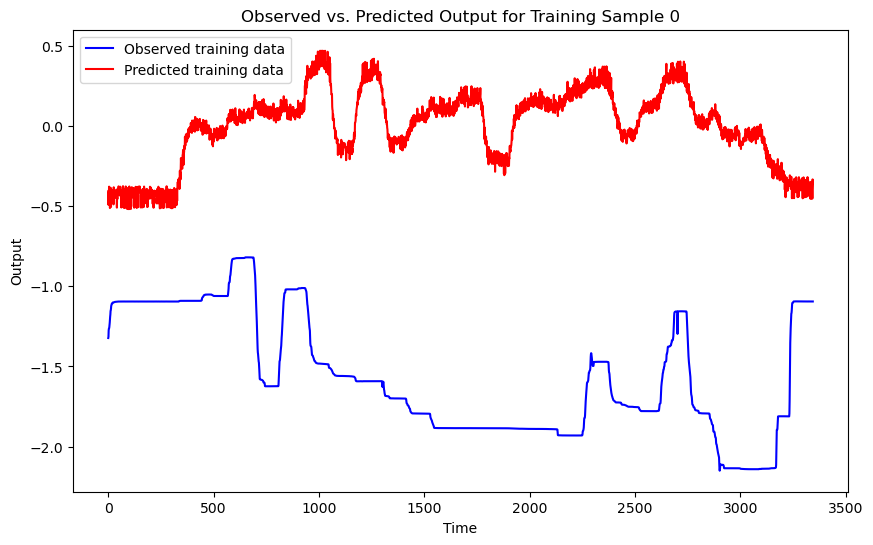

Actual data:  tensor([[-0.4164, -0.4166, -0.4164,  ..., -0.1709, -0.1707, -0.1712],
        [-2.3038, -2.3037, -2.3037,  ..., -2.3038, -2.3038, -2.3038],
        [-2.3037, -2.3037, -2.3037,  ..., -1.8030, -1.8030, -1.8030],
        [-0.3854, -0.3853, -0.3855,  ..., -0.2988, -0.2987, -0.2990]],
       dtype=torch.float64)
Predicted data:  [[-0.4064804  -0.49085036 -0.41940218 ... -0.45140588 -0.33210889
  -0.35600117]
 [-0.4064804  -0.49085036 -0.41940218 ... -0.45140588 -0.33210889
  -0.35600117]
 [-0.4064804  -0.49085036 -0.41940218 ... -0.45140588 -0.33210889
  -0.35600117]
 [-0.4064804  -0.49085036 -0.41940218 ... -0.45140588 -0.33210889
  -0.35600117]]


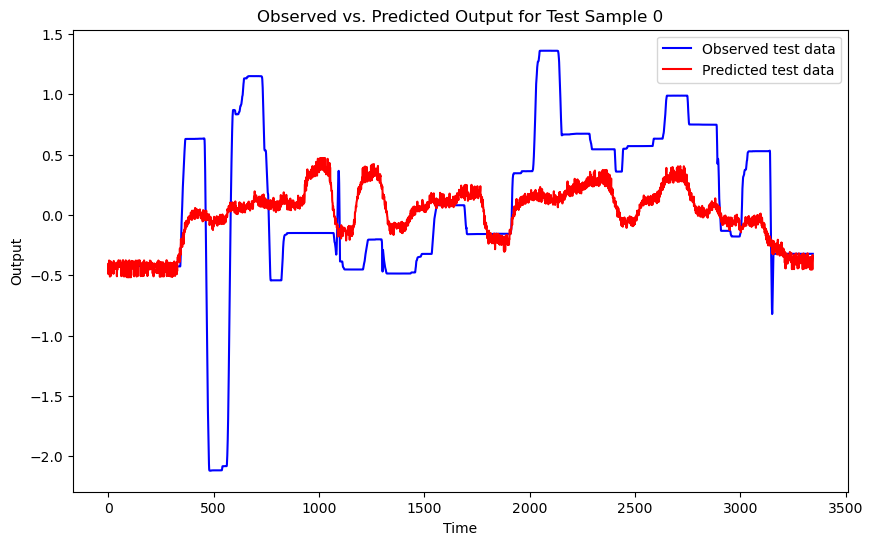

In [12]:
# Plot the predicted output against the observed y_data
# Example plot for a single time series (assuming you're plotting a specific sample)
sample_index = 0 # Index of the sample you want to plot

plt.figure(figsize=(10, 6))
plt.plot(y_data_np[sample_index,:], label="Observed training data", color="blue")
plt.plot(predicted_output_np[sample_index,:], label="Predicted training data", color="red")
plt.title("Observed vs. Predicted Output for Training Sample {}".format(sample_index))
plt.xlabel("Time")
plt.ylabel("Output")
plt.legend()
plt.show()

print("Actual data: ", y_train_std[60:80])
print("Predicted data: ", predicted_output_np[60:80])

plt.figure(figsize=(10, 6))
plt.plot(y_data2_np[sample_index,:], label="Observed test data", color="blue")
plt.plot(predicted_output2_np[sample_index,:], label="Predicted test data", color="red")
plt.title("Observed vs. Predicted Output for Test Sample {}".format(sample_index))
plt.xlabel("Time")
plt.ylabel("Output")
plt.legend()
plt.show()

### Plot weighted scattering activation map

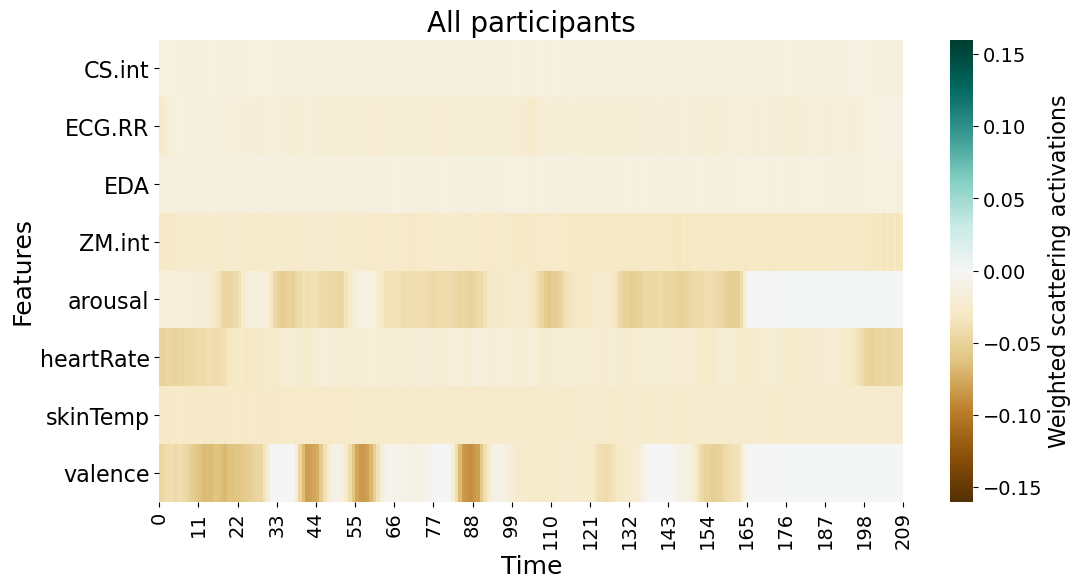

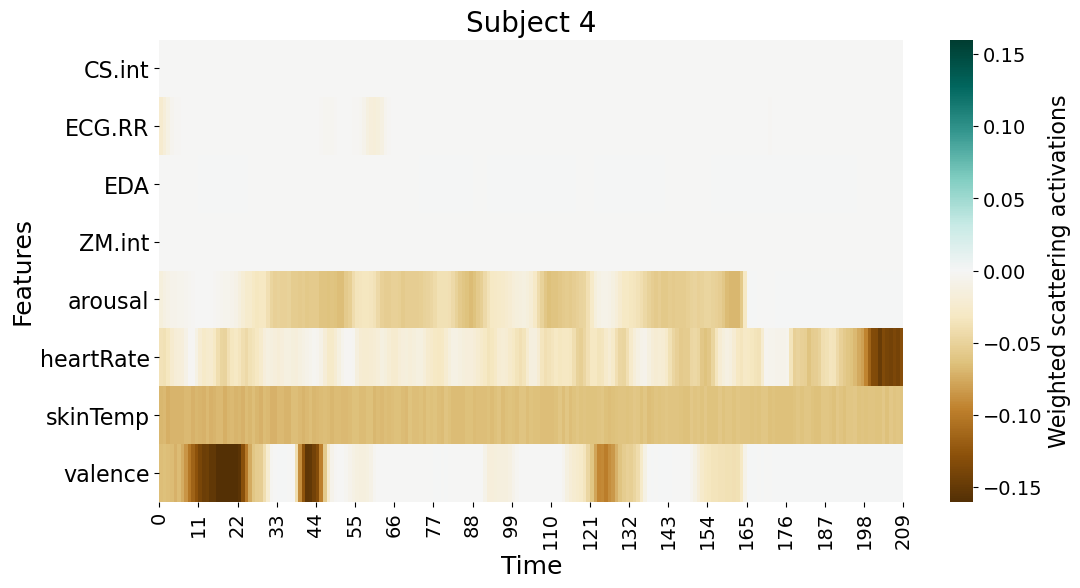

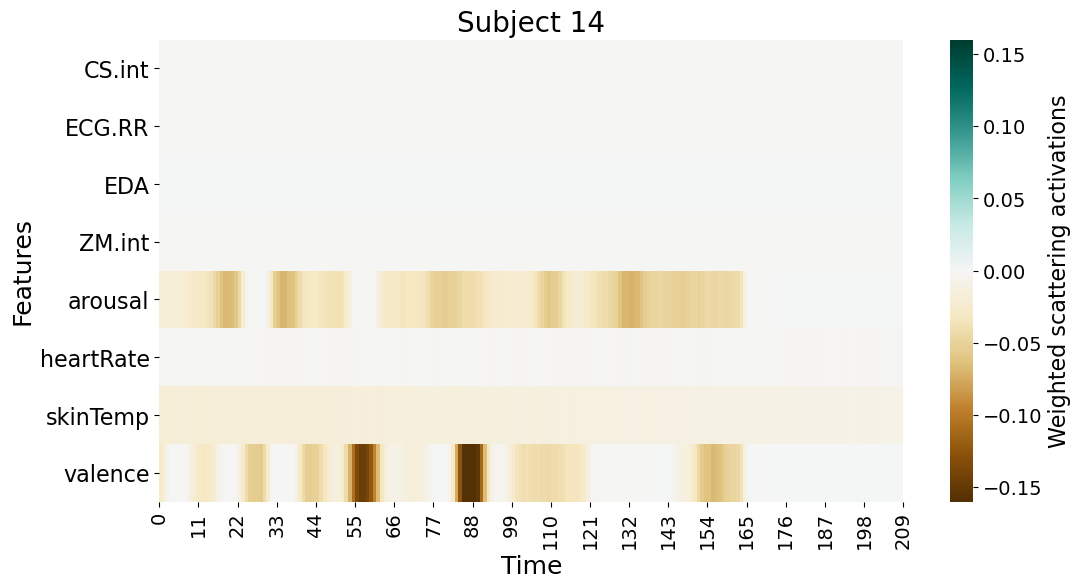

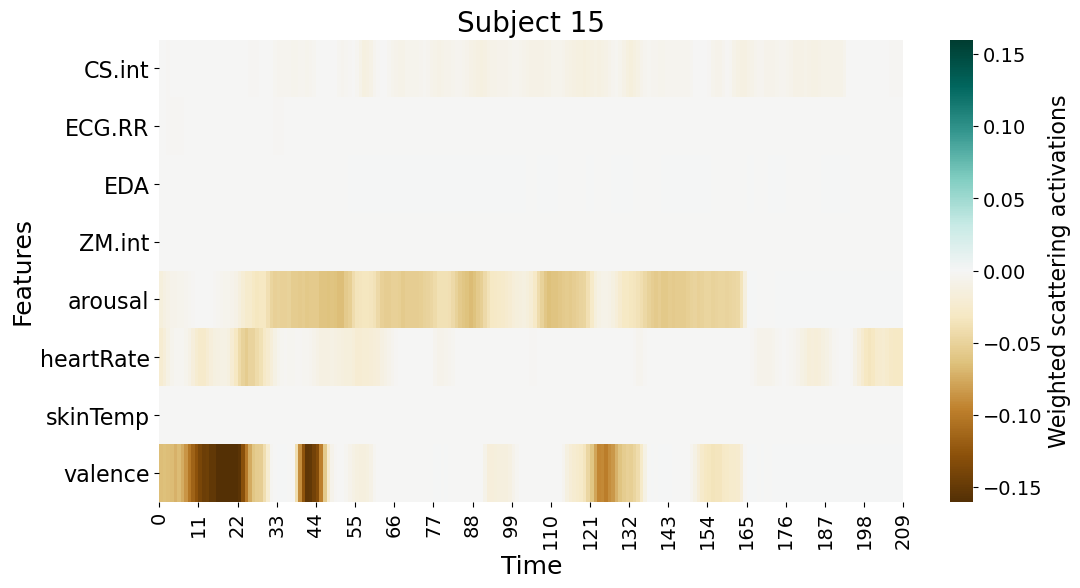

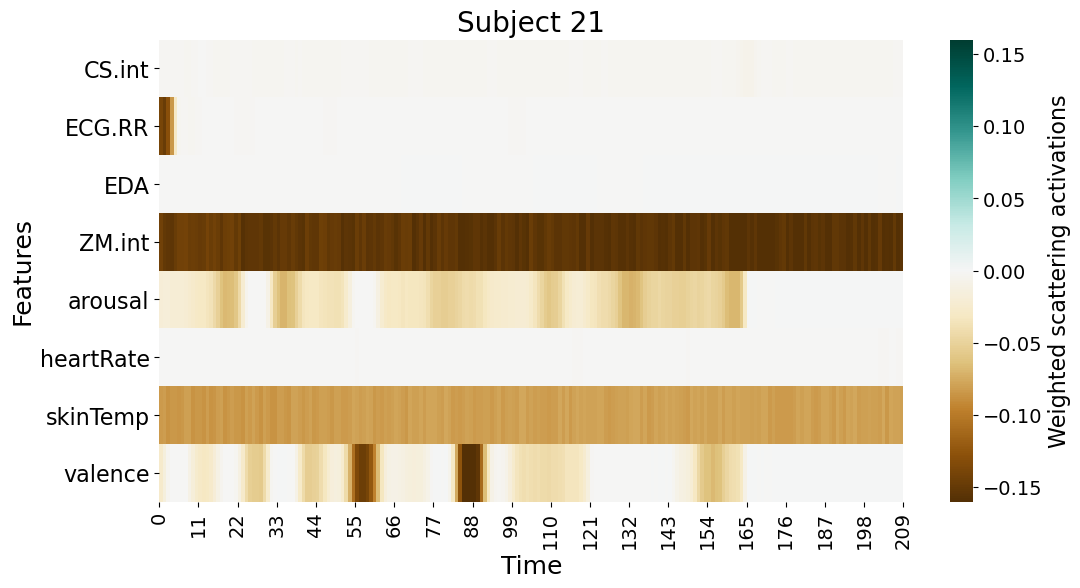

In [13]:
Features = variables[dim2]
Features[2] = "EDA" #Change GSR to EDA for electrodermal activity for broader familiarity
create_activationMap(heat_np, num_features,
                        ylabels=Features,
                         colors="BrBG", barLabel = "Weighted scattering activations",
                         title="All participants", vmin = -0.16, vmax = 0.16, savefile = f"{fig_path}ADID_HeatmapAll.pdf")


IDstoPlot = [4, 14, 15, 21]
for sample_indexi in range(len(IDstoPlot)):
    create_activationMap(heatbyPerson_np[sample_indexi,:,:], num_features,
                        ylabels=Features,vmin = -0.16, vmax = 0.16,
                         colors="BrBG", barLabel = "Weighted scattering activations",
                         title=f"Subject {IDstoPlot[sample_indexi]}", savefile = f"{fig_path}ScatteringHeatmapSubject{IDstoPlot[sample_indexi]}.pdf")